# SST-2 Dataset Sub-sampling

**Overview**

This notebook performs the following tasks:
1. **Load the full SST-2 training dataset**.
2. **Perform stratified sampling** to create two smaller training subsets: 10% and 50% of the original data, while preserving the label distribution.
3. **Save these subsets** into new directories (`data/processed_size_splits_sst2/10_percent` and `data/processed_size_splits_sst2/50_percent`) for use in downstream experiments.
4. **Copy the validation and test sets** to the new directories to ensure consistent evaluation.
5. **Conduct a brief Exploratory Data Analysis (EDA)** to verify the distributions of the new subsets.

In [24]:
import pandas as pd
import os
import pickle
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## 1. Data Loading

In [25]:
SOURCE_DATA_DIR = '../data/processed'
OUTPUT_DIR = '../data/processed_size_splits_sst2'

TRAIN_FILE = 'sst2_train.pkl'
VAL_FILE = 'sst2_val.pkl'
TEST_FILE = 'sst2_test.pkl'

SUBSET_CONFIGS = {
    '10_percent': 0.10,
    '50_percent': 0.50
}

# Load the full training data
train_path = os.path.join(SOURCE_DATA_DIR, TRAIN_FILE)
with open(train_path, 'rb') as f:
    full_train_data = pickle.load(f)

full_train_df = pd.DataFrame(full_train_data)
print(f"Loaded {len(full_train_df)} samples from the original training set.")
full_train_df.head()

Loaded 54576 samples from the original training set.


,texts,token_lengths,word_counts,text_lengths,labels,processed_texts
0,come by once in a while with flawless amounts ...,19.0,17,85,1,come by once in a while with flawless amounts ...
1,savagely,4.0,1,9,0,savagely
2,intriguing and alluring,6.0,3,24,1,intriguing and alluring
3,all its visual panache and compelling supporti...,11.0,8,60,1,all its visual panache and compelling supporti...
4,intermezzo strain,6.0,2,18,1,intermezzo strain


## 2. Stratified Sampling and Subsets Saving

In [26]:
def create_and_save_subset(df, subset_name, fraction):
    """Performs stratified sampling and saves the data."""
    print(f"\n--- Creating subset: {subset_name} ({fraction*100:.0f}%) ---")
    
    # Create output directory
    subset_dir = os.path.join(OUTPUT_DIR, subset_name)
    os.makedirs(subset_dir, exist_ok=True)
    
    # Perform stratified split
    _, subset_df = train_test_split(
        df,
        test_size=fraction,
        stratify=df['labels'],  
        random_state=42
    )
    
    print(f"Sampled {len(subset_df)} instances.")
    
    # Convert column names to match SST2Dataset
    subset_to_save = subset_df.rename(columns={'texts': 'text', 'labels': 'label'})
    
    # Save the new training subset
    subset_train_path = os.path.join(subset_dir, TRAIN_FILE)
    with open(subset_train_path, 'wb') as f:
        pickle.dump(subset_to_save.to_dict('records'), f)
    print(f"Saved training subset to: {subset_train_path}")
    
    # Copy validation and test files
    for filename in [VAL_FILE, TEST_FILE]:
        source_path = os.path.join(SOURCE_DATA_DIR, filename)
        dest_path = os.path.join(subset_dir, filename)
        shutil.copy(source_path, dest_path)
        print(f"Copied {filename} to {subset_dir}")
        
    return subset_df

# Create all configured subsets
subsets = {}
for name, frac in SUBSET_CONFIGS.items():
    subsets[name] = create_and_save_subset(full_train_df, name, frac)



--- Creating subset: 10_percent (10%) ---
Sampled 5458 instances.
Saved training subset to: ../data/processed_size_splits_sst2/10_percent/sst2_train.pkl
Copied sst2_val.pkl to ../data/processed_size_splits_sst2/10_percent
Copied sst2_test.pkl to ../data/processed_size_splits_sst2/10_percent

--- Creating subset: 50_percent (50%) ---
Sampled 27288 instances.
Saved training subset to: ../data/processed_size_splits_sst2/50_percent/sst2_train.pkl
Copied sst2_val.pkl to ../data/processed_size_splits_sst2/50_percent
Copied sst2_test.pkl to ../data/processed_size_splits_sst2/50_percent


## 3. EDA: Verify Distributions

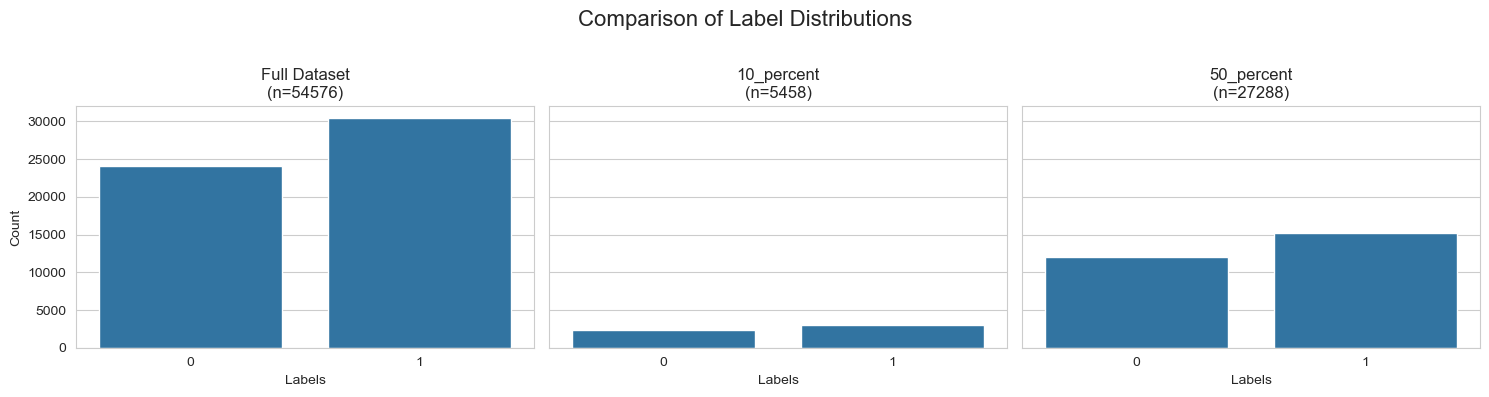

In [27]:
# Compare label distributions
fig, axes = plt.subplots(1, len(subsets) + 1, figsize=(15, 4), sharey=True)
fig.suptitle('Comparison of Label Distributions', fontsize=16)

# Original Data
sns.countplot(x='labels', data=full_train_df, ax=axes[0])
axes[0].set_title(f"Full Dataset\n(n={len(full_train_df)})")
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Count')

# Subsets
for i, (name, df) in enumerate(subsets.items()):
    sns.countplot(x='labels', data=df, ax=axes[i+1])
    axes[i+1].set_title(f"{name}\n(n={len(df)})")
    axes[i+1].set_xlabel('Labels')
    axes[i+1].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


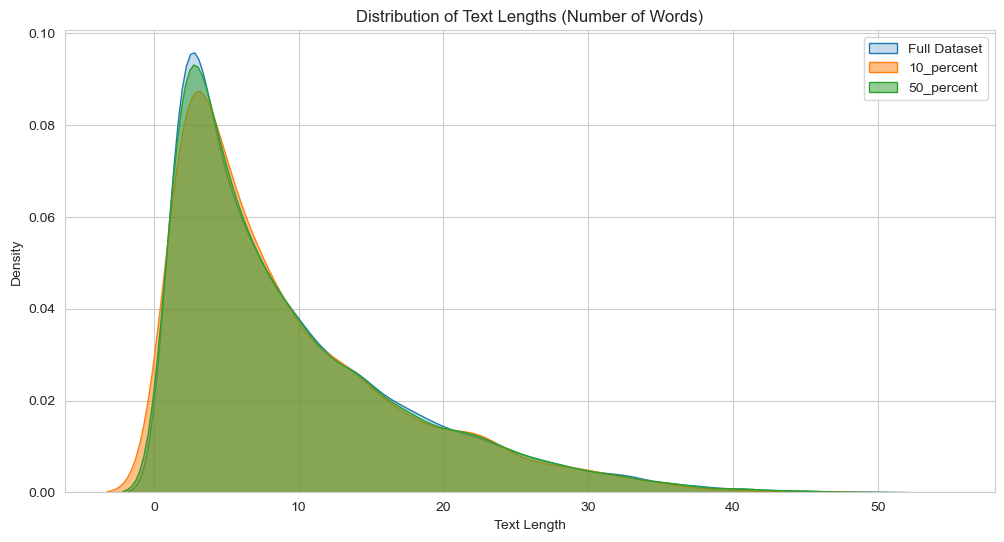

In [28]:
# Compare text length distributions
full_train_df['text_length'] = full_train_df['texts'].apply(lambda x: len(x.split()))
for name, df in subsets.items():
    df['text_length'] = df['texts'].apply(lambda x: len(x.split())) 

plt.figure(figsize=(12, 6))
sns.kdeplot(full_train_df['text_length'], label='Full Dataset', fill=True)
for name, df in subsets.items():
    sns.kdeplot(df['text_length'], label=name, fill=True, alpha=0.5)

plt.title('Distribution of Text Lengths (Number of Words)')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()